# Identifying entities in notes

Goal of this notebook is to determine how successful entity identification is using


In [1]:
%matplotlib inline
from __future__ import print_function
import os
from pyspark import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as sql
import pyspark.sql.types as types
#from pyspark.sql.functions import udf, length
import matplotlib.pyplot as plt
import numpy
import math
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import pyspark.ml.feature as feature

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [18]:
# Load Processed Parquet
sqlContext = SQLContext(sc)
notes = sqlContext.read.parquet("../data/idigbio_notes.parquet")
total_records = notes.count()
print(total_records)
# Small sample of the df
notes = notes.sample(withReplacement=False, fraction=0.1)
notes.cache()
print(notes.count())

3230857
323356


In [19]:
# Still have some problems with the document field having nulls and
# being empty. Not sure where nulls came from but likely the 
# empties are really whitespace
#notes = notes.select(sql.trim(notes["document"]).alias("document"))\
#    .dropna(subset="document")\
#    .filter(sql.length("document") > 0)


#print(notes.count())

# Moved the above to the text_characterization notebook and re-wrote parquet
# should be clean now.

notes.select(notes["document"])\
    .orderBy(notes["document"])\
    .show(10, truncate=False)
notes.select(notes["document"])\
    .orderBy(notes["document"], ascending=False)\
    .show(10, truncate=False)

+--------+
|document|
+--------+
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
|!       |
+--------+
only showing top 10 rows

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|document                                                                                                                                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|♂                                                              

## Sentence detection

Does splitting in to sentences matter? Is there enough information to do this with a natural language library or should things like "," "[]", and "{}" be worked in to address semi-structured data?

## Tokenize documents


In [4]:
from lib.tokens import Tokens
tokens = Tokens()
t = tokens.tokenize("Hello, my name is Mace Windoo")
print(t)

['Hello', ',', 'my', 'name', 'is', 'Mace', 'Windoo']


In [5]:
udf_tokenize = sql.udf(tokens.tokenize, types.ArrayType(types.StringType()))

notes_w_tokens = notes.withColumn('tokens', udf_tokenize(notes['document']))
for r in notes_w_tokens.select(notes_w_tokens["tokens"]).head(50):
    print(" | ".join(r["tokens"]))
    print("\n")

returned | specimens | identified | by | RES


[ | 01°44'28 | '' | S | 51°27'21.3 | '' | W | BRASIL | : | PA | , | Melgaço | , | Caxiuanã | Estação | Cient. | Ferreira | Pena | Trilha | , | 19-22.xi.2003 | YPT | APAguiar | & | JDias | P05091 | ]


Plot | : | S18. | Photo | : | yes | .


5 | of | 81 | specs. | to | USNM | , | 86-3126 | ; | 5 | of | 81 | specs. | to | Kochi | U. | , | 86-3127 | ; | alcohol | specs. | in | 2 | jars. | Cruise | 18B | , | sta. | 770 | ; | same | as | sta. | LK | 66-120 | .


Frequent. | In | sandy | soil | on | ridge | top | in | rough | breaks | with | Cercocarpus | montanus | , | Parthenium | alpinum | and | Musineon | .


[ | 23°38'56.9 | '' | S | 45°53'48.8 | '' | W | , | BRASIL | : | SP | , | Salesópolis | , | Res. | , | Biol. | Boracéia | , | Trilha | dos | Pilões | , | P2.2 | , | margem | do | rio | , | 12-15.i.2003 | , | YPT | , | 863m | , | ACC | Macedo | & | JS | Freitas | ]


Substrate | : | intact | coarse | down | wood | > | 5 | centimeter | di

In [6]:
notes_w_tokens.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- occurrenceID: string (nullable = true)
 |-- catalogNumber: string (nullable = true)
 |-- county: string (nullable = true)
 |-- institutionCode: string (nullable = true)
 |-- country: string (nullable = true)
 |-- countryCode: string (nullable = true)
 |-- stateProvince: string (nullable = true)
 |-- family: string (nullable = true)
 |-- recordedBy: string (nullable = true)
 |-- order: string (nullable = true)
 |-- specificEpithet: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- scientificName: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- fieldNotes: string (nullable = true)
 |-- occurrenceRemarks: string (nullable = true)
 |-- eventRemarks: string (nullable = true)
 |-- document: string (nullable = true)
 |-- document_len: integer (nullable = true)
 |-- fieldNotes_len: integer (nullable = true)
 |-- eventRemarks_len: integer (null

In [7]:
from lib.pos_tags import PosTags
pos_tags = PosTags()

pos = pos_tags.tag(t)
print(pos)
print(type(pos))
print(type(pos[0]))
print(type(pos[0]["tag"]))
print(pos[0])

[{'tag': 'NNP', 'word': 'Hello'}, {'tag': ',', 'word': ','}, {'tag': 'PRP$', 'word': 'my'}, {'tag': 'NN', 'word': 'name'}, {'tag': 'VBZ', 'word': 'is'}, {'tag': 'NNP', 'word': 'Mace'}, {'tag': 'NNP', 'word': 'Windoo'}]
<type 'list'>
<type 'dict'>
<type 'str'>
{'tag': 'NNP', 'word': 'Hello'}


In [8]:
udf_part_of_speech = sql.udf(pos_tags.tag, types.ArrayType(
                                    types.MapType(
                                        types.StringType(),
                                        types.StringType()
                                    )
                                )
                            )

notes_w_tokens2 = notes_w_tokens.withColumn('pos', 
                                            udf_part_of_speech(notes_w_tokens['tokens']))

for r in notes_w_tokens2.select(notes_w_tokens2["pos"]).head(50):
    s = ""
    for p in r["pos"]:
        s = s + p["word"] + " (" + p["tag"] + ") | "
    print(s + "\n")

returned (VBD) | specimens (NNS) | identified (VBD) | by (IN) | RES (NNP) | 

[ (NN) | 01°44'28 (CD) | '' ('') | S (NNP) | 51°27'21.3 (CD) | '' ('') | W (NNP) | BRASIL (NNP) | : (:) | PA (NNP) | , (,) | Melgaço (NNP) | , (,) | Caxiuanã (NNP) | Estação (NNP) | Cient. (NNP) | Ferreira (NNP) | Pena (NNP) | Trilha (NNP) | , (,) | 19-22.xi.2003 (CD) | YPT (NNP) | APAguiar (NNP) | & (CC) | JDias (NNP) | P05091 (NNP) | ] (NNP) | 

Plot (NN) | : (:) | S18. (NNP) | Photo (NNP) | : (:) | yes (NNS) | . (.) | 

5 (LS) | of (IN) | 81 (CD) | specs. (NNP) | to (TO) | USNM (NNP) | , (,) | 86-3126 (CD) | ; (:) | 5 (CD) | of (IN) | 81 (CD) | specs. (NNP) | to (TO) | Kochi (NNP) | U. (NNP) | , (,) | 86-3127 (CD) | ; (:) | alcohol (NN) | specs. (NNP) | in (IN) | 2 (CD) | jars. (NNP) | Cruise (NNP) | 18B (CD) | , (,) | sta. (NNP) | 770 (CD) | ; (:) | same (JJ) | as (IN) | sta. (NNP) | LK (NNP) | 66-120 (CD) | . (.) | 

Frequent. (NNP) | In (IN) | sandy (NN) | soil (NN) | on (IN) | ridge (NN) | top (NN) | i

In [9]:
notes_w_tokens2.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- occurrenceID: string (nullable = true)
 |-- catalogNumber: string (nullable = true)
 |-- county: string (nullable = true)
 |-- institutionCode: string (nullable = true)
 |-- country: string (nullable = true)
 |-- countryCode: string (nullable = true)
 |-- stateProvince: string (nullable = true)
 |-- family: string (nullable = true)
 |-- recordedBy: string (nullable = true)
 |-- order: string (nullable = true)
 |-- specificEpithet: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- scientificName: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- fieldNotes: string (nullable = true)
 |-- occurrenceRemarks: string (nullable = true)
 |-- eventRemarks: string (nullable = true)
 |-- document: string (nullable = true)
 |-- document_len: integer (nullable = true)
 |-- fieldNotes_len: integer (nullable = true)
 |-- eventRemarks_len: integer (null

In [10]:
# Can we work with maps natively?
notes_w_tokens2.select(notes_w_tokens2["pos"][0]["word"]).show(3, truncate=False)
# YES!

+------------+
|pos[0][word]|
+------------+
|returned    |
|[           |
|Plot        |
+------------+
only showing top 3 rows



In [28]:
# Let's go pipline our whole analysis
from lib.tokens import Tokens
from lib.pos_tags import PosTags
from lib.relations import Relations

t = Tokens()
p = PosTags()
r = Relations()

def pipeline(s):
    '''
    Given a string, return a list of relations
    '''
    return r.find(p.tag(t.tokenize(s)))

pipeline_udf = sql.udf(pipeline, types.ArrayType(
                                       types.MapType(
                                               types.StringType(), 
                                               types.MapType(
                                                       types.StringType(),
                                                       types.StringType()
                                                       )
                                               )
                                       )
                    )

In [29]:
relations = notes.withColumn("rels", pipeline_udf(notes["document"]))
relations.cache()
relations.select(relations["rels"]).show(3, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rels                                                                                                                                                                                                                                                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# How many things notes have something?
relations\
    .filter(sql.size(relations["rels"]) > 0)\
    .count()

205387

In [36]:
# And how many relations are there total?
relations\
    .select(sql.sum(sql.size(relations["rels"])))\
    .show()

+---------------+
|sum(size(rels))|
+---------------+
|         456382|
+---------------+



In [ ]:
# Maybe graph distribution of relations per record?

In [56]:
# How many nouns do we need to look up at OLS?
# these are the s and p parts of the relations.
# Can I access them directly?

# list of everything
just_rels = relations\
    .select("uuid", sql.explode("rels").alias("triple"))\
    .select(sql.col("uuid"),
            sql.col("triple")["s"]["word"].alias("subject"),
            sql.col("triple")["v"]["word"].alias("verb"),
            sql.col("triple")["p"]["word"].alias("predicate"))
    
just_rels.show()

+--------------------+----------+-----------+-----------+
|                uuid|   subject|       verb|  predicate|
+--------------------+----------+-----------+-----------+
|9eda3ea8-3a1e-4c9...|    shells|       with|   animals.|
|9eda3ea8-3a1e-4c9...|  Vouchers|         of|         PD|
|9eda3ea8-3a1e-4c9...|Originally| identified|     Elimia|
|fd0bceed-9507-4a2...|      Gift|         of|  collector|
|c725a5c6-11de-4b3...|     notes|         on|       card|
|a9bae4bd-38b1-443...|    BRASIL|          :|         SP|
|a9bae4bd-38b1-443...|       dos|     Pilões|     margem|
|a9bae4bd-38b1-443...|      null|         do|        rio|
|fab12c0a-be03-4ba...|      Date|          :|       July|
|0ef5e24e-7c9f-4ac...|      OHIO|          :|    Tuscar.|
|0ef5e24e-7c9f-4ac...|        A.|      added|12-JUL-2002|
|0ef5e24e-7c9f-4ac...|      1999|      added|12-JUL-2002|
|e8fc2552-2055-47b...|   Riffles|    defined|      Pools|
|e8fc2552-2055-47b...|      none|      swift|     Bottom|
|e8fc2552-2055

In [66]:
# Now just unique nouns that we need to look up
nouns = relations\
    .select(sql.explode("rels").alias("triple"))\
    .select(sql.lower(sql.col("triple")["s"]["word"]).alias("noun"))\
    .unionAll(
    relations\
    .select(sql.explode("rels").alias("triple"))\
    .select(sql.lower(sql.col("triple")["p"]["word"]).alias("noun"))
    )\
    .dropna()\
    .groupBy("noun")\
    .count()\
    .orderBy("count", ascending=False)
       

In [67]:
nouns.show(100)

+----------------+-----+
|            noun|count|
+----------------+-----+
|            data|16021|
|           notes|10589|
|            card|10152|
|     preparation| 9056|
|      collection| 8729|
|     12-jul-2002| 8056|
|          number| 8031|
|       precision| 7538|
|        specimen| 6727|
|            trap| 6533|
|               )| 6373|
|          flight| 5946|
|          length| 4753|
|             see| 4709|
|         storage| 4687|
|        locality| 4637|
|       specimens| 4586|
|           group| 4514|
|            alch| 4471|
|          effort| 4457|
|             acc| 4401|
|        comments| 4314|
|            note| 4098|
|          forest| 4084|
|       herbarium| 4072|
|               (| 3984|
|         habitat| 3906|
|           point| 3888|
|         section| 3782|
|           huc12| 3769|
|            etoh| 3342|
|            soil| 3205|
|          litter| 3184|
|          brasil| 3007|
|       collected| 3006|
|         flowers| 2883|
|           field| 2859|


In [68]:
nouns.count()

43716

In [69]:
# distribution of noun frequency
nouns_pdf = nouns.limit(1000).toPandas()

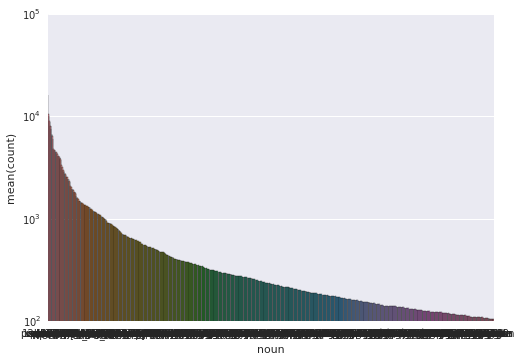

In [72]:
import seaborn as sns
ax = sns.barplot(x="noun", y="count", data=nouns_pdf)
ax.set_yscale('log')

# Leave this for later

In [11]:
# Split out words by type
# Can't figure out how to access elements of a map in a filter so 
# build something that filters the lists for us.
def find_pos(pos, part):
    '''
    Take a list of dicts that represent words tagged with
    pos information and return a list of words that match
    the requested pos
    '''
    retval = []
    for p in pos:
        if p["tag"].startswith(part):
            retval.append(p["word"])
    return retval

print(find_pos(pos, "NN"))

['Hello', 'name', 'Mace', 'Windoo']


In [12]:
# Can't figure out how to pass a single string to a UDF
find_nouns_udf = sql.udf(lambda x: find_pos(x, "NN"), types.ArrayType(types.StringType()))


In [13]:
nouns = notes_w_tokens2\
    .select(sql.explode(find_nouns_udf(notes_w_tokens2["pos"])).alias("word"))
nouns.cache()
nouns.show(3)

+---------+
|     word|
+---------+
|specimens|
|      RES|
|        [|
+---------+
only showing top 3 rows



In [14]:
noun_counts = nouns\
    .groupBy("word")\
    .count()\
    .orderBy("count", ascending=False)\
    
noun_counts.show(30)

+-----------+-----+
|       word|count|
+-----------+-----+
|          [|48044|
|          ]|32787|
|       data|16549|
|          ||11102|
|      notes|10569|
|       trap|10393|
|       card|10090|
|        See|10085|
|          (|10080|
|          S| 9586|
| collection| 9407|
|       Alch| 8578|
|     forest| 8558|
|        Co.| 8135|
|     litter| 8042|
|       soil| 7617|
|      field| 7342|
|     Number| 7096|
|     NOTEBY| 6965|
|          m| 6897|
|     flight| 6810|
|          )| 6762|
|  Herbarium| 6728|
| Collection| 6538|
|          C| 5964|
|          W| 5883|
|   specimen| 5729|
|   NOTEDATE| 5593|
|Preparation| 5074|
|preparation| 5074|
+-----------+-----+
only showing top 30 rows



In [15]:
noun_counts.cache()

DataFrame[word: string, count: bigint]

In [16]:
noun_counts.orderBy(noun_counts["count"]).show(30)

+--------------------+-----+
|                word|count|
+--------------------+-----+
|            CC-79-19|    1|
|            Feathery|    1|
|                Elof|    1|
|            watshami|    1|
|           Embidobia|    1|
|           Cionthrix|    1|
|det_comments:46.0...|    1|
|           atranonin|    1|
|             rhzomes|    1|
|det_comments:23-26mm|    1|
|         malfunction|    1|
|                L541|    1|
|         Martinsburg|    1|
|           Cupidonia|    1|
|          secretary.|    1|
|               neut.|    1|
|            radulae.|    1|
|            Bekopaka|    1|
|          L.S.Dilion|    1|
|         longiusculo|    1|
|             Granids|    1|
|          Amblydoras|    1|
|                IDS.|    1|
|            Pristers|    1|
|                Reps|    1|
|          periphyton|    1|
|      W.J.Chamberlin|    1|
| Syn=Anthrocothecium|    1|
|         OSAL0094835|    1|
|                 CMB|    1|
+--------------------+-----+
only showing t

In [17]:
noun_counts_pdf = noun_counts.limit(1000).toPandas()
print(noun_counts_pdf.head())

tuples = []
for l in noun_counts_pdf.iterrows():
    tuples.append( (l[1], l[0]) )

    word  count
0      [  48044
1      ]  32787
2   data  16549
3      |  11102
4  notes  10569


In [186]:
%matplotlib inline
from wordcloud import WordCloud

wordcloud = WordCloud().generate_from_frequencies(tuples)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# And some verbs